Link to lesson: https://carpentries-incubator.github.io/SDC-BIDS-fMRI/04-integrating_functional_data/index.html

In [1]:
import os
import matplotlib.pyplot as plt #to enable plotting within notebook
from nilearn import image as img
from nilearn import plotting as plot
from bids.layout import BIDSLayout
import numpy as np
%matplotlib inline

/home/share/git/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout=BIDSLayout(fmriprep_dir, validate=False)
T1w_files = layout.get(subject='10788', datatype='anat', suffix='preproc')
brainmask_files = layout.get(subject='10788', datatype='anat', suffix='brainmask')
func_files = layout.get(subject='10788', datatype='func', suffix='preproc')
func_mask_files = layout.get(subject='10788', datatype='func', suffix='brainmask')

/home/share/git/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [3]:
func_mni = func_files[1].path
func_mni_img = img.load_img(func_mni)

In [4]:
func_mni_img.shape

(64, 88, 66, 152)

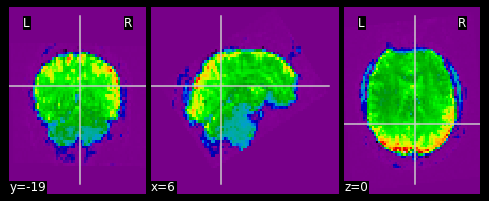

In [5]:
plot.plot_epi(func_mni_img.slicer[:,:,:,5])

In [7]:
single_vox = func_mni_img.slicer[59:60,45:46,30:31,:].get_fdata()
single_vox.shape

(1, 1, 1, 152)

In [8]:
single_vox = single_vox.flatten()
single_vox.shape

(152,)

Text(0, 0.5, 'Signal Value')

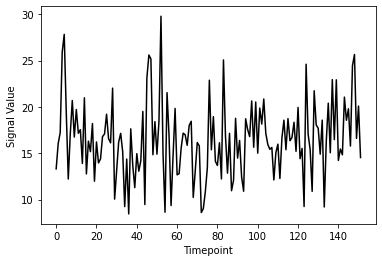

In [9]:
# Make an array counting from 0 --> 152, this will be our x-axis
x_axis = np.arange(0, single_vox.shape[0])

# Plot our x and y data, the 'k' just specifies the line color to be black
plt.plot( x_axis, single_vox, 'k')

# Label our axes
plt.xlabel('Timepoint')
plt.ylabel('Signal Value')

# Resampling

In [10]:
#Files we'll be using (Notice that we're using _space-MNI..._ which means they are normalized brains)
T1_mni = T1w_files[1].path
T1_mni_img = img.load_img(T1_mni)

In [11]:
print(T1_mni_img.shape)
print(func_mni_img.shape)

(193, 229, 193)
(64, 88, 66, 152)


## Continuous

(64, 88, 66)
(64, 88, 66, 152)


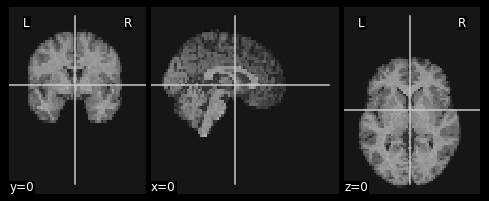

In [16]:
resamp_t1 = img.resample_to_img(source_img=T1_mni_img,target_img=func_mni_img,interpolation='continuous')
print(resamp_t1.shape)
print(func_mni_img.shape)
plot.plot_anat(resamp_t1, cut_coords=(0,0,0))

## Linear

(64, 88, 66)
(64, 88, 66, 152)


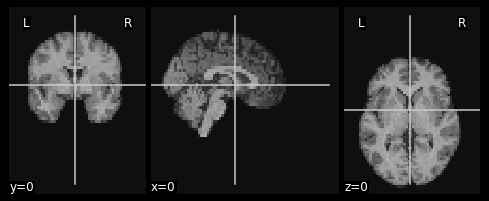

In [18]:
resamp_t1 = img.resample_to_img(source_img=T1_mni_img,target_img=func_mni_img,interpolation='linear')
print(resamp_t1.shape)
print(func_mni_img.shape)
plot.plot_anat(resamp_t1, cut_coords=(0,0,0))

## Nearest

(64, 88, 66)
(64, 88, 66, 152)


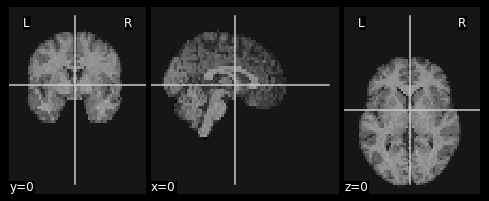

In [17]:
resamp_t1 = img.resample_to_img(source_img=T1_mni_img,target_img=func_mni_img,interpolation='nearest')
print(resamp_t1.shape)
print(func_mni_img.shape)
plot.plot_anat(resamp_t1, cut_coords=(0,0,0))

# Exercise

In [19]:
# Structural
## T1 image
ex_t1 = img.load_img(T1w_files[0].path)
## mask file
ex_t1_bm = img.load_img(brainmask_files[0].path)

#Functional
#This is the pre-processed resting state data that hasn't been standardized
ex_func = img.load_img(func_files[1].path)
#This is the associated mask for the resting state image.
ex_func_bm = img.load_img(func_mask_files[1].path)

(64, 88, 66)


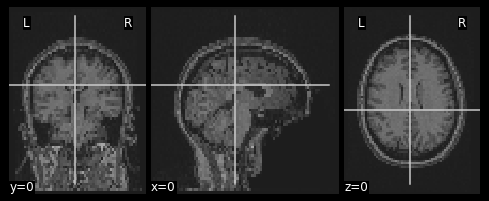

In [20]:
#Resample the T1 to the size of the functional image
resamp_ex_t1 = img.resample_to_img(source_img=ex_t1, target_img=ex_func, interpolation='continuous')
plot.plot_anat(resamp_ex_t1, cut_coords=(0,0,0))
print(resamp_ex_t1.shape)

(64, 88, 66)


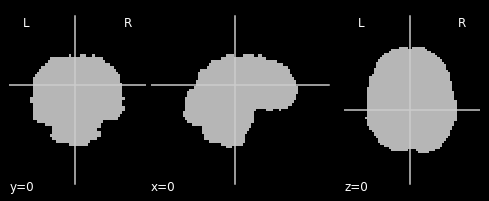

In [21]:
#Resample the T1 mask to the size of the functional mask
resamp_bm = img.resample_to_img(source_img=ex_t1_bm, target_img=ex_func_bm, interpolation='nearest')
plot.plot_anat(resamp_bm, cut_coords=(0,0,0))
print(resamp_bm.shape)

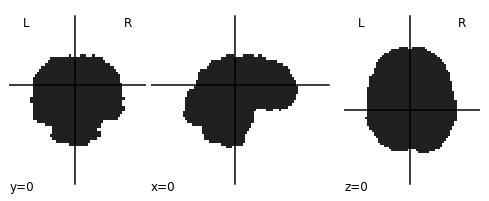

In [39]:
inverted_bm_t1 = img.math_img('-a',a=resamp_bm)
plot.plot_anat(inverted_bm_t1, cut_coords=(0,0,0))

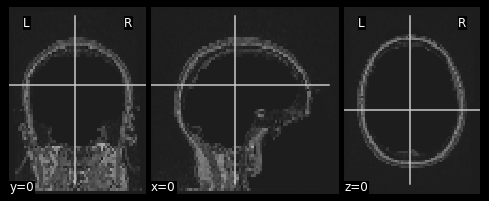

In [51]:
resamp_t1_nobrain = img.math_img('(1+b)*a', a=resamp_ex_t1, b=inverted_bm_t1)
plot.plot_anat(resamp_t1_nobrain, cut_coords=(0,0,0))

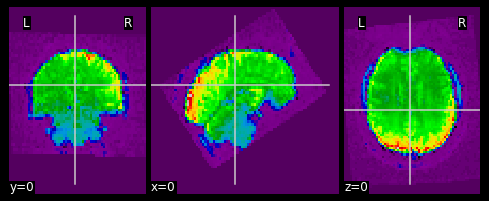

In [53]:
first_vol = ex_func.slicer[:,:,:,0]
plot.plot_epi(first_vol, cut_coords=(0,0,0))

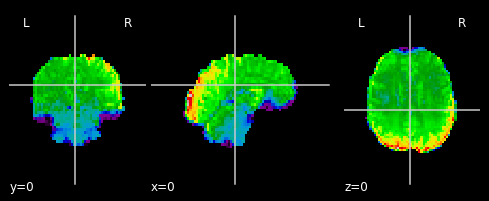

In [54]:
#Mask first_vol using ex_func_bm
masked_func = img.math_img('(b)*a', a=first_vol, b=resamp_bm)
plot.plot_epi(masked_func, cut_coords=(0,0,0))

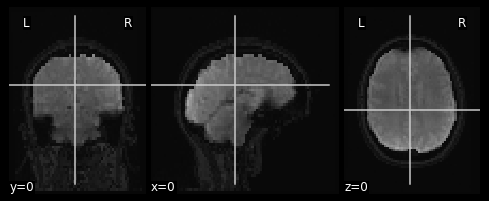

In [57]:
combined_img = img.math_img('a+b', a=resamp_t1_nobrain, b=masked_func)
plot.plot_anat(combined_img,cut_coords=(0,0,0))